In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [5]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    return hp
    # return new_amp
    # return new_phase

In [6]:
mass_ratio = 1
# mass_ratio = 0.95
total_mass = 100
approximant = "SEOBNRv4_opt"
# approximant = "SEOBNRv4P"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
t1 = -500
# t1 = -200
# t1 = -2000
# t1 = -5000
t2 = 70
dt = 0.5
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [7]:
new_times_M.shape

(1140,)

In [8]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)

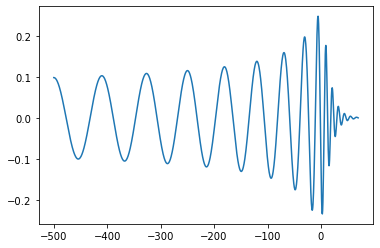

In [9]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)

In [10]:
# mass_ratios = np.linspace(1, 5, 100)
# mass_ratios = np.linspace(1, 5, 10)
# mass_ratios = np.linspace(1, 5, 20)
# mass_ratios = np.linspace(1, 1.5, 5)

mass_ratios = np.linspace(1, 5, 40)

# mass_ratios_1 = np.linspace(0, 0.6, 10)
# mass_ratios_2 = np.linspace(0.6, 0.85, 10)
# mass_ratios_3 = np.linspace(0.85, 0.99, 20)
# mass_ratios = np.concatenate((mass_ratios_1, mass_ratios_2, mass_ratios_3))

# mass_ratios = np.linspace(1, 5, 2)
# mass_ratios = np.linspace(1, 5, 5)
hps = []
for mass_ratio in mass_ratios:
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)
    hps.append(hp)
hps = np.array(hps)

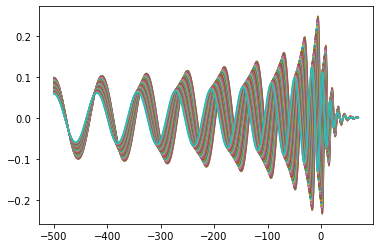

In [11]:
for hp in hps:
    plt.plot(new_times_M, hp)
# plt.xlim(-100, 100)

In [12]:
q_idxs = np.arange(len(mass_ratios))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
q_training_idxs = q_idxs[::2]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
q_training_idxs = np.concatenate((q_training_idxs, [q_idxs[-1]]))
q_validation_idxs = q_idxs[1:-1:2] 

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# q_training_idxs = q_idxs
# q_validation_idxs = q_idxs

In [13]:
q_training_idxs


array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 39])

In [14]:

q_validation_idxs


array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37])

In [15]:

len(q_idxs)


40

In [16]:

len(q_training_idxs)


21

In [17]:

len(q_validation_idxs)

19

In [18]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [19]:
len(t_idxs)

1140

In [20]:
len(t_training_idxs)

570

In [21]:
len(t_validation_idxs)

570

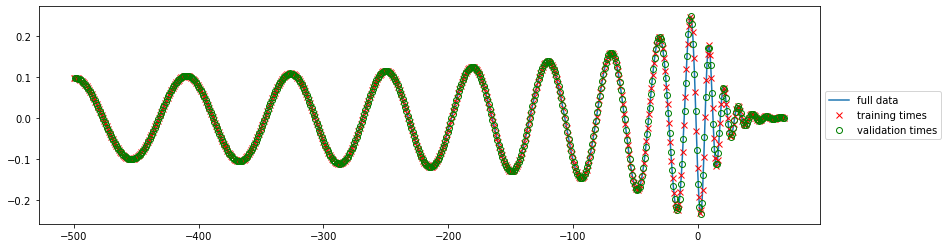

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[0], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[0][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[0][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

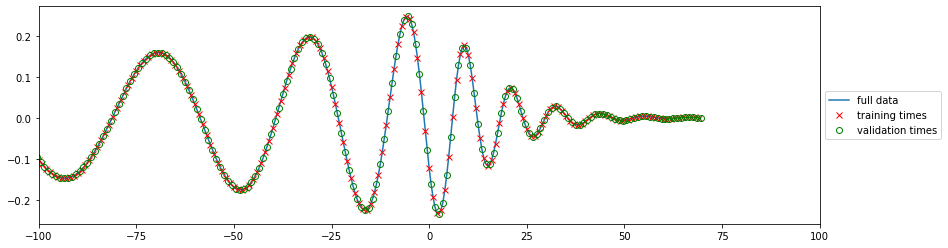

In [23]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[0], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[0][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[0][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [24]:
def build_input_single_q(t, q):
    """
    t is a matrix i.e. shape = (-1, 1)
    q is a float
    """
    q = np.ones_like(t) * q

    return np.column_stack((t, q))

In [25]:
def build_input_multiple_q(t, qs):
    """
    t is a vector
    qs is a vector
    """
    return np.row_stack([build_input_single_q(t, q) for q in qs])

In [26]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
q_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

t_scaled = t_scaler.fit_transform(new_times_M[:,np.newaxis])
q_scaled = q_scaler.fit_transform(mass_ratios[:,np.newaxis])

In [27]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [28]:
X_training = build_input_multiple_q(t_scaled[t_training_idxs], q_scaled[q_training_idxs])

In [29]:
X_validation = build_input_multiple_q(t_scaled[t_validation_idxs], q_scaled[q_validation_idxs])

In [30]:
X_training.shape

(11970, 2)

In [31]:
X_validation.shape

(10830, 2)

In [32]:
hps.shape

(40, 1140)

In [33]:
# y_training = hps[np.ix_(q_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(q_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[np.ix_(q_training_idxs, t_training_idxs)]
y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[np.ix_(q_validation_idxs, t_validation_idxs)]
y_validation = y_validation.reshape(-1, 1)

In [34]:
y_training.shape

(11970, 1)

In [35]:
y_validation.shape

(10830, 1)

In [36]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,1], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,1], y_validation, s=3)

In [37]:
dt_scaled = t_scaled.reshape(-1)[1]-t_scaled.reshape(-1)[0]
dt_scaled

0.0008779631255486642

In [38]:
fs=pycbc.types.TimeSeries(hps[0], delta_t=dt_scaled).to_frequencyseries()

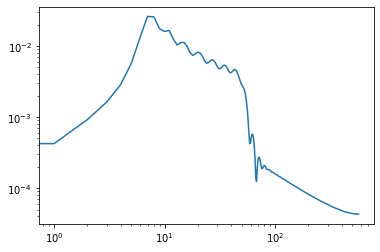

In [39]:
plt.plot(fs.sample_frequencies, np.abs(fs))
plt.xscale('log')
plt.yscale('log')

Metal device set to: Apple M1 Pro


2022-06-18 19:48:39.600681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-18 19:48:39.601544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


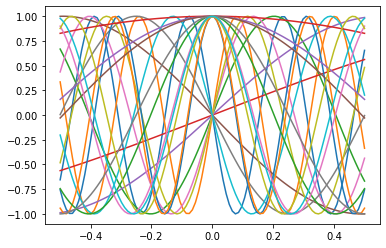

In [40]:
model_test = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    FourierFeatureProjection(gaussian_projection = 10, gaussian_scale = 2)
])
x_ = np.linspace(-0.5, 0.5, 100)
plt.plot(x_, model_test(x_));
# plt.ylim(0.98,1.01)

In [41]:
plt.plot(tf.linspace(1., 10., 20), tf.linspace(1., 10., 20)**2)

In [42]:
model_test = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 5),
    # tf.keras.layers.Dense(128, activation=tf.keras.layers.Lambda(tf.math.sin)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1),
])
x_ = np.linspace(-0.5, 0.5, 100)
plt.plot(x_, model_test(x_));
# plt.ylim(0.98,1.01)

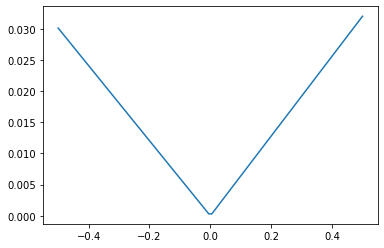

In [43]:
model_test = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    # FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 5),
    # tf.keras.layers.Dense(128, activation=tf.keras.layers.Lambda(tf.math.sin)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1),
])
x_ = np.linspace(-0.5, 0.5, 100)
plt.plot(x_, model_test(x_));
# plt.ylim(0.98,1.01)

In [82]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1"):
    activation = 'relu'
    # activation = 'linear'
    units = 256
    n_layers = 3
    # gaussian_projection = units
    gaussian_projection = 20
    # gaussian_projection = 5
    # gaussian_scale = 1

    # gaussian_scale = 20
    # gaussian_scale = 10
    gaussian_scale = 5
    # gaussian_scale = 1

    # model 1: only pass the time through the RFF encoding
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    q_input = tf.keras.Input(shape=(1,), name='q_input')
    x_t = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(time_input)
    
    
    if model_version == "1":
        x = tf.keras.layers.Concatenate()([x_t, q_input])
    elif model_version == "2":
        # x_q = FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 0.1)(q_input)
        x_q = FourierFeatureProjection(gaussian_projection = 20, gaussian_scale = 0.1)(q_input)
        
        x_t = tf.keras.layers.Dense(units, activation)(x_t)
        x_q = tf.keras.layers.Dense(units, activation)(x_q)
        # x_t = tf.keras.layers.Dense(units)(x_t)
        # x_q = tf.keras.layers.Dense(units)(x_q)
        
        x = tf.keras.layers.Concatenate()([x_t, x_q])
    else:
        raise ValueError()
    
    # x_q = tf.keras.layers.Dense(units, activation)(q_input)

    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)

    # model 2: pass both time and mass-ratio through RFF encoding
    # model 2 doesn't work so well in the q-direction :)
    # I am guessing it's because the variation of the function in q
    # is simpler than the variation in time.
    # time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    # all_inputs = tf.keras.layers.Concatenate()([time_input, q_input])
    # x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(all_inputs)
    # # x_q = tf.keras.layers.Dense(units, activation)(q_input)
    # # x = tf.keras.layers.Concatenate()([x_t, q_input])
    # # x = tf.keras.layers.Concatenate()([x_t, x_q])
    # for i in range(n_layers):
    #     x = tf.keras.layers.Dense(units, activation)(x)
    # x = tf.keras.layers.Dense(1)(x)
    # model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    history = model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    return history, model

In [83]:
# batch_size=X_train_fit.shape[0]
epochs=2000
# epochs=500
# epochs=2
# batch_size=X_training.shape[0]
# batch_size=X_training.shape[0]//2
# batch_size = 3735
# batch_size = 32
# batch_size = 128
# batch_size = 256
# batch_size = 512
# batch_size = 1024
batch_size = 2048
print(batch_size)
# epochs=3000
# batch_size=32
# epochs=100

# learning_rate = 1e-3
learning_rate = 1e-4
print(learning_rate)

2048
0.0001


In [84]:
X_training.shape

(11970, 2)

In [85]:
X_training.dtype

dtype('float64')

In [86]:
# model_version="1"
model_version="2"

In [87]:
%%time
history, model = run_model(
    X_training,
    y_training,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_validation[:,0], X_validation[:,1]], y_validation),
    learning_rate=learning_rate,
    threshold=1e-6,
    verbose=0,
    model_version=model_version,
    # threshold=3e-6
    )

Training:   0%|                                                                                      0/2000 ET…

2022-06-18 19:55:24.545320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-18 19:55:24.781769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 55.3 s, sys: 39.6 s, total: 1min 34s
Wall time: 1min 37s


In [88]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")

In [89]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [90]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

<Figure size 432x288 with 0 Axes>

In [91]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 q_input (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 fourier_feature_projection_6 (  (None, 40)          20          ['time_input[0][0]']             
 FourierFeatureProjection)                                                                        
                                                                                                  
 fourier_feature_projection_7 (  (None, 40)          20          ['q_input[0][0]']          

In [92]:
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [93]:
# model.layers[1].weights[0]

In [94]:
# w=model.layers[1].weights[0].numpy()[0]
# plt.scatter(range(len(w)), w)

In [95]:
test_input = build_input_single_q(t_scaled, q_scaled[q_training_idxs[-1]])
test_yhat = model.predict([test_input[:,0], test_input[:,1]], verbose=0)

2022-06-18 19:57:02.524460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


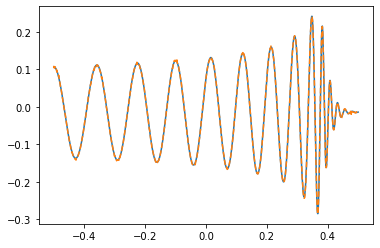

In [96]:
plt.plot(test_input[:,0], hps_scaled[q_training_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='--')
# plt.xlim(0.3, 0.5)

In [97]:
test_input = build_input_single_q(t_scaled, q_scaled[q_validation_idxs[-1]])
test_yhat = model.predict([test_input[:,0], test_input[:,1]], verbose=0)

In [98]:
%%timeit
model.predict([test_input[:,0], test_input[:,1]], verbose=0)

137 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


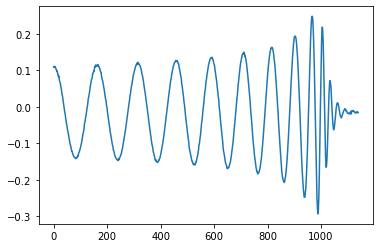

In [99]:
plt.plot(test_yhat)

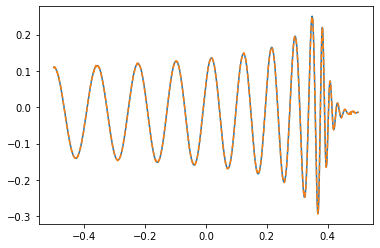

In [100]:
plt.plot(test_input[:,0], hps_scaled[q_validation_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='--')
# plt.xlim(0.3, 0.5)